In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(1024, 768, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Using TensorFlow backend.


In [ ]:
import pandas as pd
import numpy as np
import skimage
from sklearn.model_selection import train_test_split

img_folder = r'C:\Users\Kamil Ogrodowski\Desktop\Obrazowanie\218447-medical_imaging-788b05f861ac\dataset'
img_width = 1024
img_height = 768

# Read data
data = pd.read_csv(r'C:\Users\Kamil Ogrodowski\Desktop\Obrazowanie\218447-medical_imaging-788b05f861ac\dataset\GTruth.csv')

# Split to train_data, val_data, test_data
train_data, test_data = train_test_split(data)

def read_img(fileid):
    """
    Read and resize img, adjust channels. 
    Caution: This function is not independent, it uses global vars: img_folder, img_channels
    @param file: file id, int
    """
    img = skimage.io.imread(img_folder+ '\\' + str(fileid) + '.jpeg')
    img = skimage.transform.resize(img, (img_width, img_height), mode='reflect')
    # A few image are grey, duplicate them for to have 3 alpha channels.
    if(len(img.shape) < 3):
        img = np.dstack([img, img, img])
    return img
                        
# Train data
train_X = np.stack(train_data['Id'].apply(read_img))
test_X = np.stack(test_data['Id'].apply(read_img))

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [ ]:
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
# print x_train.shape
# print x_test.shape

In [ ]:
from keras.callbacks import TensorBoard

autoencoder.fit(train_X, train_X,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(test_X, test_X))

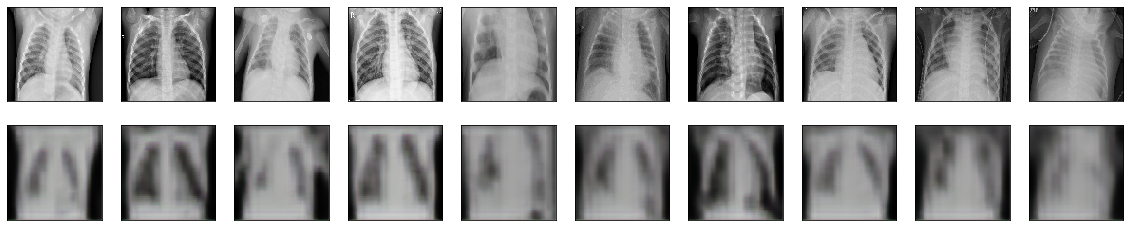

In [58]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(test_X)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_X[i].reshape(1024, 768, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(1024, 768, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [63]:
from keras.models import load_model
#10autoencoder.save('deepAutoencoderV1.h5')  # creates a HDF5 file 'my_model.h5'



In [60]:
#model = load_model('deepAutoencoderV1.h5')

In [61]:
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

ssim_table = []
for i in range(n):
    ssim_table.append(ssim(test_X[i].reshape(1024, 768, 3), decoded_imgs[i].reshape(1024, 768, 3), data_range=decoded_imgs[i].reshape(1024, 768, 3).max() - decoded_imgs[i].reshape(1024, 768, 3).min(), multichannel=True))
ssim_table


[0.475695960482116,
 0.4633769913926009,
 0.6004761249046947,
 0.47967342348642955,
 0.6399556836781622,
 0.5815317203364455,
 0.4103285087869575,
 0.5436500481498342,
 0.5096738782761955,
 0.5926572271049132]

In [62]:
#PSNR high means: Mean square error between the original image and reconstructed image is very low. It implies that the the has been properly restored. In the other way, the restored image quality is better.
#If PSNR value is low; the quality of the restored image is very bad. 
psnr_table = []
for i in range(n):
    psnr_table.append(psnr(test_X[i].reshape(1024, 768, 3), decoded_imgs[i].reshape(1024, 768, 3), data_range=decoded_imgs[i].reshape(1024, 768, 3).max() - decoded_imgs[i].reshape(1024, 768, 3).min()))
psnr_table

[15.64614558931558,
 16.776925966772204,
 16.886820110654696,
 14.557974787362664,
 18.793303493525585,
 20.573054879304994,
 17.813844795355095,
 18.53827641951126,
 19.607548896663065,
 20.904340806283408]